In [50]:
# ===============================
# Logistic Regression on Car_Insurance_Claim Dataset
# Dataset file: Car_Insurance_Claim.csv
# Target column: OUTCOME (Binary: 0/1)
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report
)

# ===============================
# Load Dataset
# Data set link : "https://www.kaggle.com/datasets/sagnik1511/car-insurance-data/data"
# ===============================
csv_path = os.path.join("Car_Insurance_Claim.csv")
df = pd.read_csv(csv_path)  # <-- use your uploaded dataset path

#print("Dataset Shape:", df.shape)
#print("Columns:", df.columns)
print(df.describe())

df.head(5)

                  ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [51]:
# ===============================
# Handle Missing Values
# ===============================

target_col = "OUTCOME"

# Check missing values
print("\nMissing values:\n", df.isnull().sum())

# BEFORE dropping missing
y_before = df[target_col]
count_before = y_before.value_counts(dropna=False)

# AFTER dropping missing rows
df_after = df.dropna()
y_after = df_after[target_col]
count_after = y_after.value_counts(dropna=False)

# align both indexes (so missing categories appear too)
summary = pd.DataFrame({
    "before_dropna": count_before,
    "after_dropna": count_after
}).fillna(0).astype(int)

# dropped count + drop %
summary["dropped_rows"] = summary["before_dropna"] - summary["after_dropna"]
summary["drop_percent"] = (summary["dropped_rows"] / summary["before_dropna"] * 100).round(2)

print(summary)


Missing values:
 ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64
         before_dropna  after_dropna  dropped_rows  drop_percent
OUTCOME                                                         
0.0               6867          5613          1254         18.26
1.0               3133          2536           597         19.06


In [52]:
# ===============================
# Basic Cleanup
# ===============================

# Remove duplicates if any
df_after = df_after.drop_duplicates()

# Dropping column "ID" (it is just an identifier, not useful for prediction)
if "ID" in df.columns:
    df_after.drop(columns=["ID"], inplace=True)

# Converting POSTAL_CODE as type category
df_after["POSTAL_CODE"] = df["POSTAL_CODE"].astype("category")

# Seperating features and target
X = df_after.drop(["OUTCOME"], axis=1)
y = df_after["OUTCOME"]

# Identifing numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_features, categorical_features

(['CREDIT_SCORE',
  'VEHICLE_OWNERSHIP',
  'MARRIED',
  'CHILDREN',
  'ANNUAL_MILEAGE',
  'SPEEDING_VIOLATIONS',
  'DUIS',
  'PAST_ACCIDENTS'],
 ['AGE',
  'GENDER',
  'RACE',
  'DRIVING_EXPERIENCE',
  'EDUCATION',
  'INCOME',
  'VEHICLE_YEAR',
  'POSTAL_CODE',
  'VEHICLE_TYPE'])

In [53]:
# Standard scaling the numerical features and one hot encoding the categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#Train_Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Preprocessing the features
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)


logreg_model = LogisticRegression(max_iter=1000)

#Training the model
logreg_model.fit(X_train_p, y_train)

#Preciditing the output
y_pred = logreg_model.predict(X_test_p)
y_prob = logreg_model.predict_proba(X_test_p)[:, 1]


# ===============================
# Evalution Metrics
# ===============================
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print("Accuracy:", accuracy)
print("AUC:", auc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MCC:", mcc)

print(classification_report(y_test, y_pred))

Accuracy: 0.8404907975460123
AUC: 0.9151083407539328
Precision: 0.7556935817805382
Recall: 0.7199211045364892
F1 Score: 0.7373737373737373
MCC: 0.6233106133337188
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      1123
         1.0       0.76      0.72      0.74       507

    accuracy                           0.84      1630
   macro avg       0.82      0.81      0.81      1630
weighted avg       0.84      0.84      0.84      1630



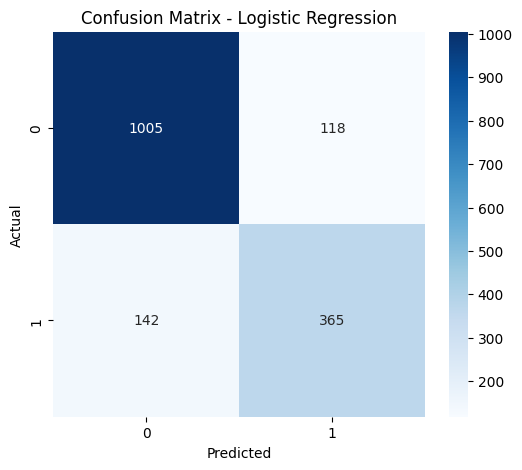

In [54]:
# ===============================
# Confusion Matrix
# ===============================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [55]:
def build_model():
    # train or load weights
    return logreg_model